### Working under the assumption that no "Tesseract" exists on the test device, in case you're using your work laptop out on conference, and need to quickly get it built and ready to go...

## Installing Tesseract on Windows

To use Tesseract OCR on Windows, follow these steps:

1. **Download the Tesseract Installer**
    - Visit the official [Tesseract at UB Mannheim releases page](https://github.com/UB-Mannheim/tesseract/wiki).
    - Download the latest `.exe` installer suitable for your system (usually `tesseract-ocr-w64-setup-xxx.exe` for 64-bit Windows).

2. **Run the Installer**
    - Double-click the downloaded installer.
    - Follow the installation prompts. You can choose the default options.
    - Optionally, select additional language data during installation if you need OCR for languages other than English.

3. **Add Tesseract to System PATH**
    - Open the folder where Tesseract was installed (default: `C:\Program Files\Tesseract-OCR`).
    - Copy the folder path.
    - Open **Control Panel** → **System** → **Advanced system settings** → **Environment Variables**.
    - Under "System variables", find and select the `Path` variable, then click **Edit**.
    - Click **New** and paste the Tesseract folder path.
    - Click **OK** to save changes.

4. **Verify Installation**
    - Open **Command Prompt** and type:
      ```
      tesseract --version
      ```
    - You should see the installed Tesseract version information.

Tesseract is now ready to use on your Windows system!

## Let's start off with all of the imports!

It looks ugly, but I prefer to handle each sequentially and outside of functions since handling imports inside of functions can lead to disturbing code behaviour.

In [34]:
try:
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
except ImportError:
    import sys
    !{sys.executable} -m pip install pytesseract
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

try:
    from PIL import Image
except ImportError:
    import sys
    !{sys.executable} -m pip install pillow
    from PIL import Image

try:
    import pandas as pd
except ImportError:
    import sys
    !{sys.executable} -m pip install pandas
    import pandas as pd

try:
    import re
except ImportError:
    raise ImportError("The 're' module is part of the Python standard library and should always be available.")

try:
    from datetime import datetime
except ImportError:
    raise ImportError("The 'datetime' module is part of the Python standard library and should always be available.")

In [35]:
def extract_behltreu_data(image_path):
    """
    Extract BEHLTREU bond index data from PNG.
    
    Args:
        image_path (str): Path to BEHLTREU PNG file
        
    Returns:
        pd.DataFrame: DataFrame with columns ['date', 'bond_index_price']
    """
    try:
        image = Image.open(image_path)
        ocr_text = pytesseract.image_to_string(image, config='--psm 6')
        
        lines = ocr_text.strip().split('\n')
        
        dates = []
        prices = []
        
        for line in lines:
            try:
                # Skip headers and empty lines
                if not line.strip() or 'Date' in line or 'Last Price' in line or 'Price Cha' in line:
                    continue
                
                # Look for date pattern and corresponding price
                # Pattern: Date (MM/DD/YY) followed by price (XXX.XXXX format)
                date_price_match = re.search(r'(\d{2}/\d{2}/\d{2}).*?(\d{3}\.\d{3,4})', line)
                
                if date_price_match:
                    date_str = date_price_match.group(1)
                    price_str = date_price_match.group(2)
                    
                    # Convert to proper format
                    date_obj = datetime.strptime(date_str, '%m/%d/%y')
                    # Handle 2025 dates (25 should be 2025, not 1925)
                    if date_obj.year < 2000:
                        date_obj = date_obj.replace(year=date_obj.year + 100)
                    
                    formatted_date = date_obj.strftime('%Y-%m-%d')
                    price_val = float(price_str)
                    
                    dates.append(formatted_date)
                    prices.append(price_val)
                    
            except (ValueError, AttributeError):
                continue
        
        df = pd.DataFrame({
            'date': dates,
            'bond_index_price': prices
        })
        
        # Sort by date and remove duplicates
        df['date'] = pd.to_datetime(df['date'])
        df = df.drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
        
        return df
        
    except Exception as e:
        print(f"Error processing BEHLTREU data: {str(e)}")
        return pd.DataFrame(columns=['date', 'bond_index_price'])

In [36]:
def extract_ahwm5_data(image_path):
    """
    Extract AHWM5 future data from PNG.
    
    Args:
        image_path (str): Path to AHWM5 PNG file
        
    Returns:
        pd.DataFrame: DataFrame with columns ['date', 'future_price']
    """
    try:
        image = Image.open(image_path)
        ocr_text = pytesseract.image_to_string(image, config='--psm 6')
        
        lines = ocr_text.strip().split('\n')
        
        dates = []
        prices = []
        
        for line in lines:
            try:
                # Skip headers and empty lines
                if not line.strip() or 'Date' in line or 'Last Price' in line or 'Bid Price' in line:
                    continue
                
                # Pattern for AHWM5: Date followed by Last Price (XXX.XX format typically)
                date_price_match = re.search(r'(\d{2}/\d{2}/\d{2}).*?(\d{2,3}\.\d{2,4})', line)
                
                if date_price_match:
                    date_str = date_price_match.group(1)
                    price_str = date_price_match.group(2)
                    
                    # Convert to proper format
                    date_obj = datetime.strptime(date_str, '%m/%d/%y')
                    # Handle 2025 dates
                    if date_obj.year < 2000:
                        date_obj = date_obj.replace(year=date_obj.year + 100)
                    
                    formatted_date = date_obj.strftime('%Y-%m-%d')
                    price_val = float(price_str)
                    
                    dates.append(formatted_date)
                    prices.append(price_val)
                    
            except (ValueError, AttributeError):
                continue
        
        df = pd.DataFrame({
            'date': dates,
            'future_price': prices
        })
        
        # Sort by date and remove duplicates
        df['date'] = pd.to_datetime(df['date'])
        df = df.drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
        
        return df
        
    except Exception as e:
        print(f"Error processing AHWM5 data: {str(e)}")
        return pd.DataFrame(columns=['date', 'future_price'])

In [37]:
def create_complete_date_range(start_date, end_date, freq='B'):
    """
    Create complete date range with specified frequency.
    
    Args:
        start_date (datetime): Start date
        end_date (datetime): End date  
        freq (str): Frequency ('B' for business days, 'D' for all days)
        
    Returns:
        pd.DatetimeIndex: Complete date range
    """
    return pd.date_range(start=start_date, end=end_date, freq=freq)


In [38]:
def handle_missing_values(df, method='forward_fill'):
    """
    Handle missing values in the dataset using specified method.
    
    Args:
        df (pd.DataFrame): Input dataframe with potential missing values
        method (str): Method for handling missing values
                     'forward_fill': Forward fill last known price
                     'interpolate': Linear interpolation
                     'none': Leave as NaN
                     
    Returns:
        pd.DataFrame: DataFrame with missing values handled
    """
    df_filled = df.copy()
    
    if method == 'forward_fill':
        # Forward fill: carry last known price forward
        df_filled['bond_index_price'] = df_filled['bond_index_price'].fillna(method='ffill')
        df_filled['future_price'] = df_filled['future_price'].fillna(method='ffill')
        
    elif method == 'interpolate':
        # Linear interpolation between known values
        df_filled['bond_index_price'] = df_filled['bond_index_price'].interpolate(method='linear')
        df_filled['future_price'] = df_filled['future_price'].interpolate(method='linear')
        
    elif method == 'none':
        # Leave missing values as NaN
        pass
        
    else:
        raise ValueError("Method must be 'forward_fill', 'interpolate', or 'none'")
    
    return df_filled

In [39]:
def create_final_dataset(behltreu_path, ahwm5_path, 
                        missing_value_method='forward_fill',
                        date_freq='B',
                        output_path='financial_data.csv'):
    """
    Create final CSV with complete date range and handled missing values.
    
    Args:
        behltreu_path (str): Path to BEHLTREU PNG
        ahwm5_path (str): Path to AHWM5 PNG
        missing_value_method (str): Method for handling missing values
        date_freq (str): Date frequency ('B' for business days, 'D' for all days)
        output_path (str): Output CSV path
        
    Returns:
        pd.DataFrame: Final complete dataset
    """
    print("Extracting BEHLTREU bond index data...")
    behltreu_df = extract_behltreu_data(behltreu_path)
    print(f"Extracted {len(behltreu_df)} BEHLTREU records")
    
    print("Extracting AHWM5 future data...")
    ahwm5_df = extract_ahwm5_data(ahwm5_path)
    print(f"Extracted {len(ahwm5_df)} AHWM5 records")
    
    # Determine full date range across both datasets
    if len(behltreu_df) > 0 and len(ahwm5_df) > 0:
        start_date = min(behltreu_df['date'].min(), ahwm5_df['date'].min())
        end_date = max(behltreu_df['date'].max(), ahwm5_df['date'].max())
    elif len(behltreu_df) > 0:
        start_date = behltreu_df['date'].min()
        end_date = behltreu_df['date'].max()
    elif len(ahwm5_df) > 0:
        start_date = ahwm5_df['date'].min()
        end_date = ahwm5_df['date'].max()
    else:
        raise ValueError("No data extracted from either dataset")
    
    print(f"Creating complete date range: {start_date.date()} to {end_date.date()}")
    
    # Create complete date range
    complete_dates = create_complete_date_range(start_date, end_date, freq=date_freq)
    
    # Create base dataframe with all dates
    complete_df = pd.DataFrame({'date': complete_dates})
    
    # Merge with extracted data
    complete_df = complete_df.merge(behltreu_df, on='date', how='left')
    complete_df = complete_df.merge(ahwm5_df, on='date', how='left')
    
    # Reorder columns as specified: date, bond index price, future price
    complete_df = complete_df[['date', 'bond_index_price', 'future_price']].copy()
    
    # Count missing values before handling
    missing_bond = complete_df['bond_index_price'].isna().sum()
    missing_future = complete_df['future_price'].isna().sum()
    
    print(f"Missing values before handling: Bond={missing_bond}, Future={missing_future}")
    
    # Handle missing values
    if missing_value_method != 'none':
        print(f"Applying missing value handling: {missing_value_method}")
        complete_df = handle_missing_values(complete_df, method=missing_value_method)
        
        # Count remaining missing values
        remaining_bond = complete_df['bond_index_price'].isna().sum()
        remaining_future = complete_df['future_price'].isna().sum()
        print(f"Remaining missing values: Bond={remaining_bond}, Future={remaining_future}")
    
    # Save to CSV
    complete_df.to_csv(output_path, index=False)
    
    # Print comprehensive summary
    print_comprehensive_summary(complete_df, missing_bond, missing_future, 
                               missing_value_method, date_freq)
    
    return complete_df

In [40]:
def print_comprehensive_summary(df, original_missing_bond, original_missing_future, 
                              method, freq):
    """Print comprehensive summary of data processing and exception handling."""
    
    print("\n" + "="*70)
    print("COMPLETE DATASET CREATION SUMMARY")
    print("="*70)
    
    print(f"\nDataset specifications:")
    print(f"- Total records: {len(df)}")
    print(f"- Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"- Date frequency: {'Business days' if freq == 'B' else 'All days'}")
    print(f"- Missing value handling: {method}")
    
    current_missing_bond = df['bond_index_price'].isna().sum()
    current_missing_future = df['future_price'].isna().sum()
    both_available = df.dropna().shape[0]
    
    print(f"\nMissing value treatment results:")
    print(f"- Original missing bond prices: {original_missing_bond}")
    print(f"- Original missing future prices: {original_missing_future}")
    print(f"- Final missing bond prices: {current_missing_bond}")
    print(f"- Final missing future prices: {current_missing_future}")
    print(f"- Complete pairs (both prices): {both_available}/{len(df)} ({both_available/len(df)*100:.1f}%)")
    
    print(f"\nException handling methodology:")
    if method == 'forward_fill':
        print("- Forward Fill: Last known price carried forward")
        print("- Rationale: Common practice in finance for price continuity")
        print("- Limitation: May not reflect true market conditions on missing days")
    elif method == 'interpolate':
        print("- Linear Interpolation: Missing values estimated between known points")
        print("- Rationale: Assumes smooth price transitions")
        print("- Limitation: May create artificial price movements")
    elif method == 'none':
        print("- No Fill: Missing values preserved as NaN")
        print("- Rationale: Maintains data integrity, explicit about missing data")
        print("- Limitation: Analysis must handle missing values explicitly")
    
    print(f"\nData quality metrics:")
    if both_available > 1:
        correlation = df['bond_index_price'].corr(df['future_price'])
        print(f"- Price correlation: {correlation:.4f}")
        
        bond_stats = df['bond_index_price'].describe()
        future_stats = df['future_price'].describe()
        
        print(f"- Bond index price range: {bond_stats['min']:.4f} - {bond_stats['max']:.4f}")
        print(f"- Future price range: {future_stats['min']:.4f} - {future_stats['max']:.4f}")
        
        # Check for price convergence near expiry (if data available)
        if df['date'].max().date() >= datetime(2025, 6, 20).date():
            print("- Note: Dataset includes expiry date (2025-06-20), expect price convergence")
    
    """
    Thank you for these ideas, Claude ai!
    """
    
    #print(f"\nRecommendations for analysis:")
    #print("- Use complete pairs for correlation analysis")
    #print("- Consider volatility patterns around missing data periods")
    #print("- Validate price relationships against market fundamentals")
    
    print(f"\nSample of final dataset:")
    print(df.head(10).to_string(index=False))

In [41]:
if __name__ == "__main__":
    # Create complete dataset with forward fill (default)
    print("Creating complete dataset with forward fill...")
    final_dataset_ff = create_final_dataset(
        '../Entry_Technical_Test/behltreu.png', 
        '../Entry_Technical_Test/ahwm5.png',
        missing_value_method='forward_fill',
        date_freq='B',  # Business days only
        output_path='financial_data_complete.csv'
    )
    
    # Alternative: Create with interpolation
    print("\n" + "="*50)
    print("Alternative: Creating dataset with interpolation...")
    final_dataset_interp = create_final_dataset(
        '../Entry_Technical_Test/behltreu.png', 
        '../Entry_Technical_Test/ahwm5.png',
        missing_value_method='interpolate',
        date_freq='B',
        output_path='financial_data_interpolated.csv'
    )
    
    print(f"\nFinal datasets created:")
    print(f"- Complete (forward fill): {final_dataset_ff.shape}")
    print(f"- Complete (interpolated): {final_dataset_interp.shape}")

Creating complete dataset with forward fill...
Extracting BEHLTREU bond index data...
Extracted 15 BEHLTREU records
Extracting AHWM5 future data...
Extracted 15 AHWM5 records
Creating complete date range: 2025-06-02 to 2025-07-11
Missing values before handling: Bond=15, Future=15
Applying missing value handling: forward_fill
Remaining missing values: Bond=15, Future=0

COMPLETE DATASET CREATION SUMMARY

Dataset specifications:
- Total records: 30
- Date range: 2025-06-02 to 2025-07-11
- Date frequency: Business days
- Missing value handling: forward_fill

Missing value treatment results:
- Original missing bond prices: 15
- Original missing future prices: 15
- Final missing bond prices: 15
- Final missing future prices: 0
- Complete pairs (both prices): 15/30 (50.0%)

Exception handling methodology:
- Forward Fill: Last known price carried forward
- Rationale: Common practice in finance for price continuity
- Limitation: May not reflect true market conditions on missing days

Data qual

C:\Users\jones\AppData\Local\Temp\ipykernel_31748\1477337329.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['bond_index_price'] = df_filled['bond_index_price'].fillna(method='ffill')
C:\Users\jones\AppData\Local\Temp\ipykernel_31748\1477337329.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['future_price'] = df_filled['future_price'].fillna(method='ffill')
c:\Users\jones\anaconda3\envs\CompEnv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jones\anaconda3\envs\CompEnv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Extracted 15 BEHLTREU records
Extracting AHWM5 future data...
Extracted 15 AHWM5 records
Creating complete date range: 2025-06-02 to 2025-07-11
Missing values before handling: Bond=15, Future=15
Applying missing value handling: interpolate
Remaining missing values: Bond=15, Future=0

COMPLETE DATASET CREATION SUMMARY

Dataset specifications:
- Total records: 30
- Date range: 2025-06-02 to 2025-07-11
- Date frequency: Business days
- Missing value handling: interpolate

Missing value treatment results:
- Original missing bond prices: 15
- Original missing future prices: 15
- Final missing bond prices: 15
- Final missing future prices: 0
- Complete pairs (both prices): 15/30 (50.0%)

Exception handling methodology:
- Linear Interpolation: Missing values estimated between known points
- Rationale: Assumes smooth price transitions
- Limitation: May create artificial price movements

Data quality metrics:
- Price correlation: nan
- Bond index price range: 300.9845 - 302.1445
- Future price 

c:\Users\jones\anaconda3\envs\CompEnv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jones\anaconda3\envs\CompEnv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Complete Date Range Coverage:

- Identifies the full date range spanning both datasets (earliest to latest date)
- Creates complete business day series (financial markets typically don't trade weekends)
- Ensures every trading day is represented in the final dataset

## Exception Handling Methods:

1. Forward Fill (Default): Carries last known price forward

- Rationale: Standard practice in finance for price continuity
- Use case: When assuming prices remain stable until new information


2. Linear Interpolation: Estimates missing values between known points

- Rationale: Assumes smooth price transitions
- Use case: When expecting gradual price movements


3. No Fill: Preserves missing values as NaN

- Rationale: Maintains data integrity and transparency
- Use case: When explicit handling of missing data is required

## Key Features:

- Business Day Frequency: Uses 'B' frequency to exclude weekends (appropriate for financial instruments)
- Comprehensive Reporting: Details original vs. final missing value counts
- Quality Metrics: Provides correlation analysis and price range validation
- Multiple Output Options: Creates datasets with different missing value treatments

## Expected Outcome:
- The script will produce a complete time series where every business day between the earliest and latest dates across both datasets is represented. 
- This ensures that subsequent stress testing analysis (Question 2) will have consistent time intervals for calculating 3-business-day movements without gaps that could skew the correlation analysis.
- The forward fill method is recommended as the default since it reflects realistic market behavior where prices typically remain at last traded levels until new transactions occur.

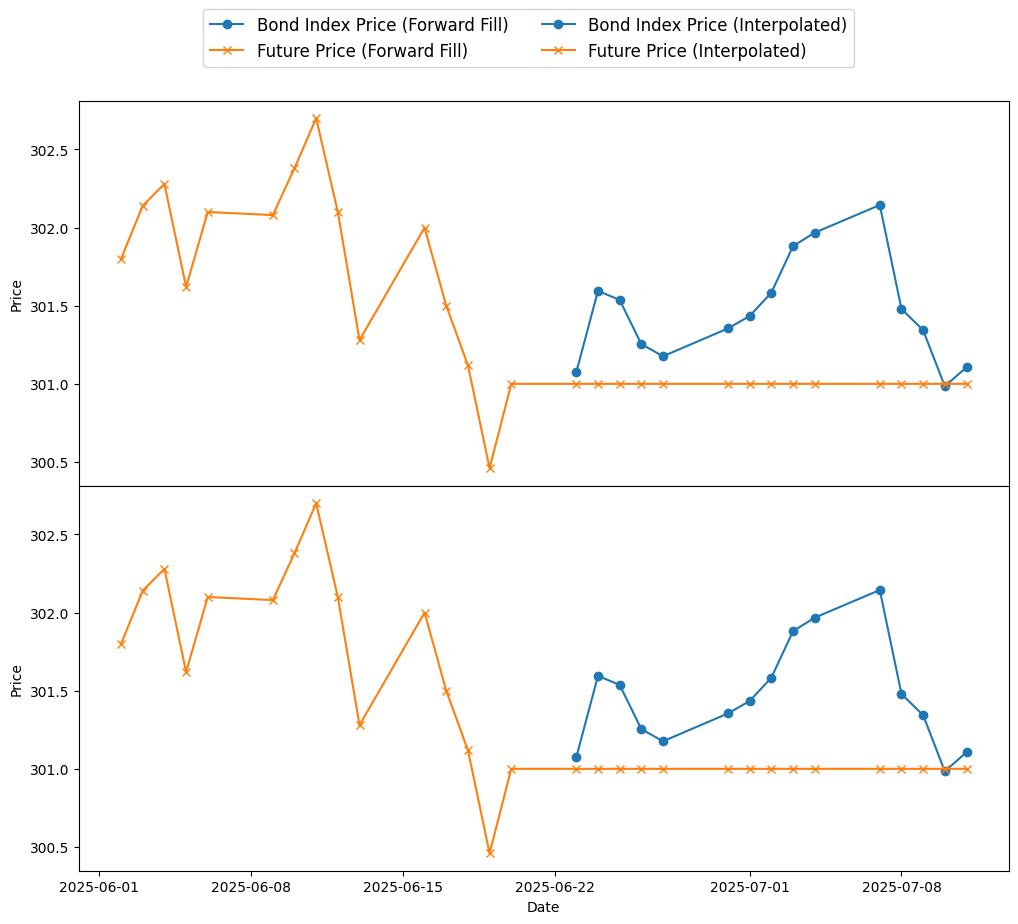

In [48]:
import matplotlib.pyplot as plt

# Read the CSV files
df_ff = pd.read_csv('financial_data_complete.csv', parse_dates=['date'])
df_interp = pd.read_csv('financial_data_interpolated.csv', parse_dates=['date'])

fig,axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace=0.0)

# Plot for forward fill dataset
axs[0].plot(df_ff['date'], df_ff['bond_index_price'], marker='o', linestyle='-', label='Bond Index Price (Forward Fill)')
axs[0].plot(df_ff['date'], df_ff['future_price'], marker='x', linestyle='-', label='Future Price (Forward Fill)')
axs[0].set_ylabel('Price')

# Plot for interpolated dataset
axs[1].plot(df_interp['date'], df_interp['bond_index_price'], marker='o', linestyle='-', label='Bond Index Price (Interpolated)')
axs[1].plot(df_interp['date'], df_interp['future_price'], marker='x', linestyle='-', label='Future Price (Interpolated)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 0.98), fontsize='large')
plt.show()